In [1]:
mkdir pdf_reports


In [1]:
import os
import pytesseract
import re
import pandas as pd
import cv2
from pdf2image import convert_from_path
from PIL import Image

# If you're on Windows, set your Tesseract path here
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

folder_path = "pdf_reports"  # <- your PDF folder
output_data = []

# Loop through all PDFs in the folder
for file in os.listdir(folder_path):
    if file.endswith(".pdf"):
        full_path = os.path.join(folder_path, file)

        try:
            pages = convert_from_path(full_path, dpi=300)
            temp_img = file.replace('.pdf', '.png')
            pages[0].save(temp_img, 'PNG')

            # Read and preprocess image
            img = cv2.imread(temp_img)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
            text = pytesseract.image_to_string(thresh)
            os.remove(temp_img)

            data = {'Date': file.replace('.pdf', '')}

            # Regex extraction
            if (m := re.search(r'Average Frequency\s*[:\-]?\s*(\d+\.\d+)', text)):
                data['Average Frequency'] = float(m.group(1))
            if (m := re.search(r'Max\s+(\d+\.\d+)\s+(\d{2}:\d{2}:\d{2})', text)):
                data['Max Inst Freq'] = float(m.group(1))
                data['Max Inst Time'] = m.group(2)
            if (m := re.search(r'Min\s+(\d+\.\d+)\s+(\d{2}:\d{2}:\d{2})', text)):
                data['Min Inst Freq'] = float(m.group(1))
                data['Min Inst Time'] = m.group(2)

            match_15 = re.findall(r'15 minute Average Frequency[\s\S]*?Max\s+(\d+\.\d+)\s+(\d{2}:\d{2}:\d{2})[\s\S]*?Min\s+(\d+\.\d+)\s+(\d{2}:\d{2}:\d{2})', text)
            if match_15:
                mf, mt, nf, nt = match_15[0]
                data['15-min Max Freq'] = float(mf)
                data['15-min Max Time'] = mt
                data['15-min Min Freq'] = float(nf)
                data['15-min Min Time'] = nt

            excursions = re.findall(r'below\s+(\d+\.\d+)\s+Hz\s+(\d+)', text)
            for level, count in excursions:
                data[f'Excursions < {level} Hz'] = int(count)

            if (m := re.search(r'Frequency Variation Index\s*[:\-]?\s*(\d+\.\d+)', text)):
                data['FDI'] = float(m.group(1))
            if (m := re.search(r'Standard Deviation\s*[:\-]?\s*(\d+\.\d+)', text)):
                data['Std Dev'] = float(m.group(1))
            if (m := re.search(r'Mileage\s*[:\-]?\s*(\d+\.\d+)', text)):
                data['Mileage'] = float(m.group(1))

            output_data.append(data)

        except Exception as e:
            print(f"Error processing {file}: {e}")

# Convert to DataFrame
df = pd.DataFrame(output_data)

# Save to CSV
df.to_csv("compiled_frequency_report.csv", index=False)
df.head()


C:\Users\rjesh\anaconda3\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (107346888 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\rjesh\anaconda3\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93500000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Date  Average Frequency  Max Inst Freq Max Inst Time  \
0  Frequency 01.01.24             50.003         50.322      16:01:40   
1  Frequency 01.01.25             50.007         50.301      14:01:20   
2  Frequency 01.02.24             50.011            NaN           NaN   
3  Frequency 01.02.25             49.998            NaN           NaN   
4  Frequency 01.03.24             49.997         50.284      18:02:30   

   Excursions < 49.97 Hz  Excursions < 50.00 Hz     FDI  Std Dev  Mileage  \
0                  111.0                  176.0  0.0617   0.0789     50.6   
1                  156.0                  182.0  0.0398   0.0629     49.1   
2                  123.0                  167.0  0.0379   0.0605     48.7   
3                  160.0                  179.0  0.0287   0.0536     43.7   
4                  161.0                  189.0  0.0427   0.0653     51.4   

   Min Inst Freq Min Inst Time  15-min Max Freq 15-min Max Time  \
0            NaN           NaN              NaN             NaN   
1         49.791      19:33:30           50.301        14:01:20   
2         49.723      21:06:40              NaN             NaN   
3         49.816      14:56:10              NaN             NaN   
4            NaN           NaN              NaN             NaN   

   15-min Min Freq 15-min Min Time  
0              NaN             NaN  
1           49.791        19:33:30  
2              NaN             NaN  
3              NaN             NaN  
4              NaN             NaN

In [4]:
# --------------------------
# 📌 1. Import Libraries
# --------------------------
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# 📌 2. Load the Data
# --------------------------
df = pd.read_csv('compiled_frequency_report.csv')

# --------------------------
# 📌 3. Strip Prefix & Convert Date
# --------------------------
df['Date'] = df['Date'].astype(str).str.replace('Frequency ', '', regex=False)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)

# --------------------------
# 📌 4. Drop Bad Dates & Sort
# --------------------------
df_sorted = df.dropna(subset=['Date']).sort_values(by='Date').reset_index(drop=True)

# --------------------------
# 📌 5. Handle Missing Values
# --------------------------
numeric_cols = df_sorted.select_dtypes(include=['float64', 'int64']).columns
df_sorted[numeric_cols] = df_sorted[numeric_cols].fillna(method='ffill').fillna(method='bfill')

time_cols = [col for col in df_sorted.columns if 'Time' in col]
df_sorted[time_cols] = df_sorted[time_cols].fillna('Unknown')

# --------------------------
# 📌 6. Save Cleaned Data
# --------------------------
df_sorted.to_csv('cleaned_frequency_report_FINAL.csv', index=False)
print("✅ Cleaned Date range:", df_sorted['Date'].min(), "to", df_sorted['Date'].max())
print("✅ Cleaned file saved: cleaned_frequency_report_FINAL.csv")






✅ Cleaned Date range: 2023-04-01 00:00:00 to 2025-07-04 00:00:00
✅ Cleaned file saved: cleaned_frequency_report_FINAL.csv


✅ Date range: 2023-04-01 00:00:00 to 2025-07-04 00:00:00


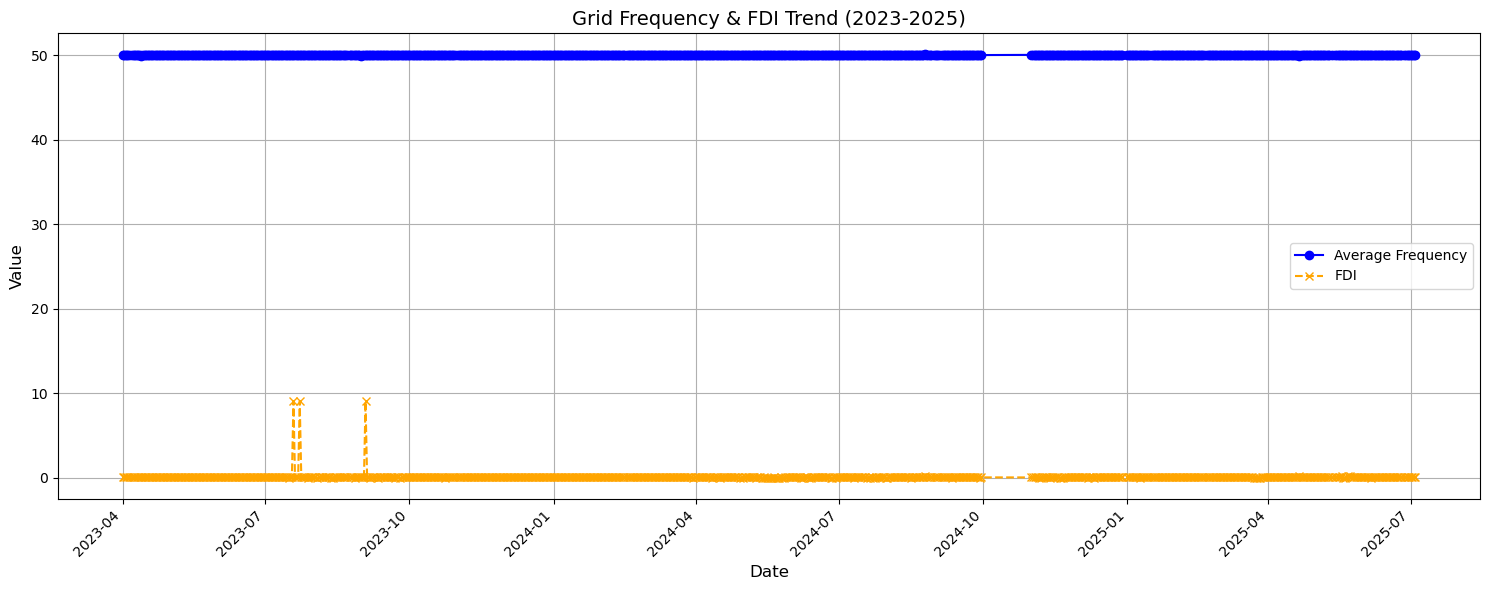

In [5]:
# --------------------------
# 📌 1. Import Clean Data
# --------------------------
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_frequency_report_FINAL.csv')
df['Date'] = pd.to_datetime(df['Date'])

print("✅ Date range:", df['Date'].min(), "to", df['Date'].max())

# --------------------------
# 📌 2. Plot Frequency & FDI Trends
# --------------------------
plt.figure(figsize=(15, 6))

plt.plot(df['Date'], df['Average Frequency'], marker='o', linestyle='-', color='blue', label='Average Frequency')
plt.plot(df['Date'], df['FDI'], marker='x', linestyle='--', color='orange', label='FDI')

plt.title("Grid Frequency & FDI Trend (2023-2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   782 non-null    object 
 1   Average Frequency      772 non-null    float64
 2   Max Inst Freq          559 non-null    float64
 3   Max Inst Time          559 non-null    object 
 4   Excursions < 49.97 Hz  772 non-null    float64
 5   Excursions < 50.00 Hz  767 non-null    float64
 6   FDI                    767 non-null    float64
 7   Std Dev                772 non-null    float64
 8   Mileage                770 non-null    float64
 9   Min Inst Freq          494 non-null    float64
 10  Min Inst Time          494 non-null    object 
 11  15-min Max Freq        332 non-null    float64
 12  15-min Max Time        332 non-null    object 
 13  15-min Min Freq        332 non-null    float64
 14  15-min Min Time        332 non-null    object 
dtypes: flo

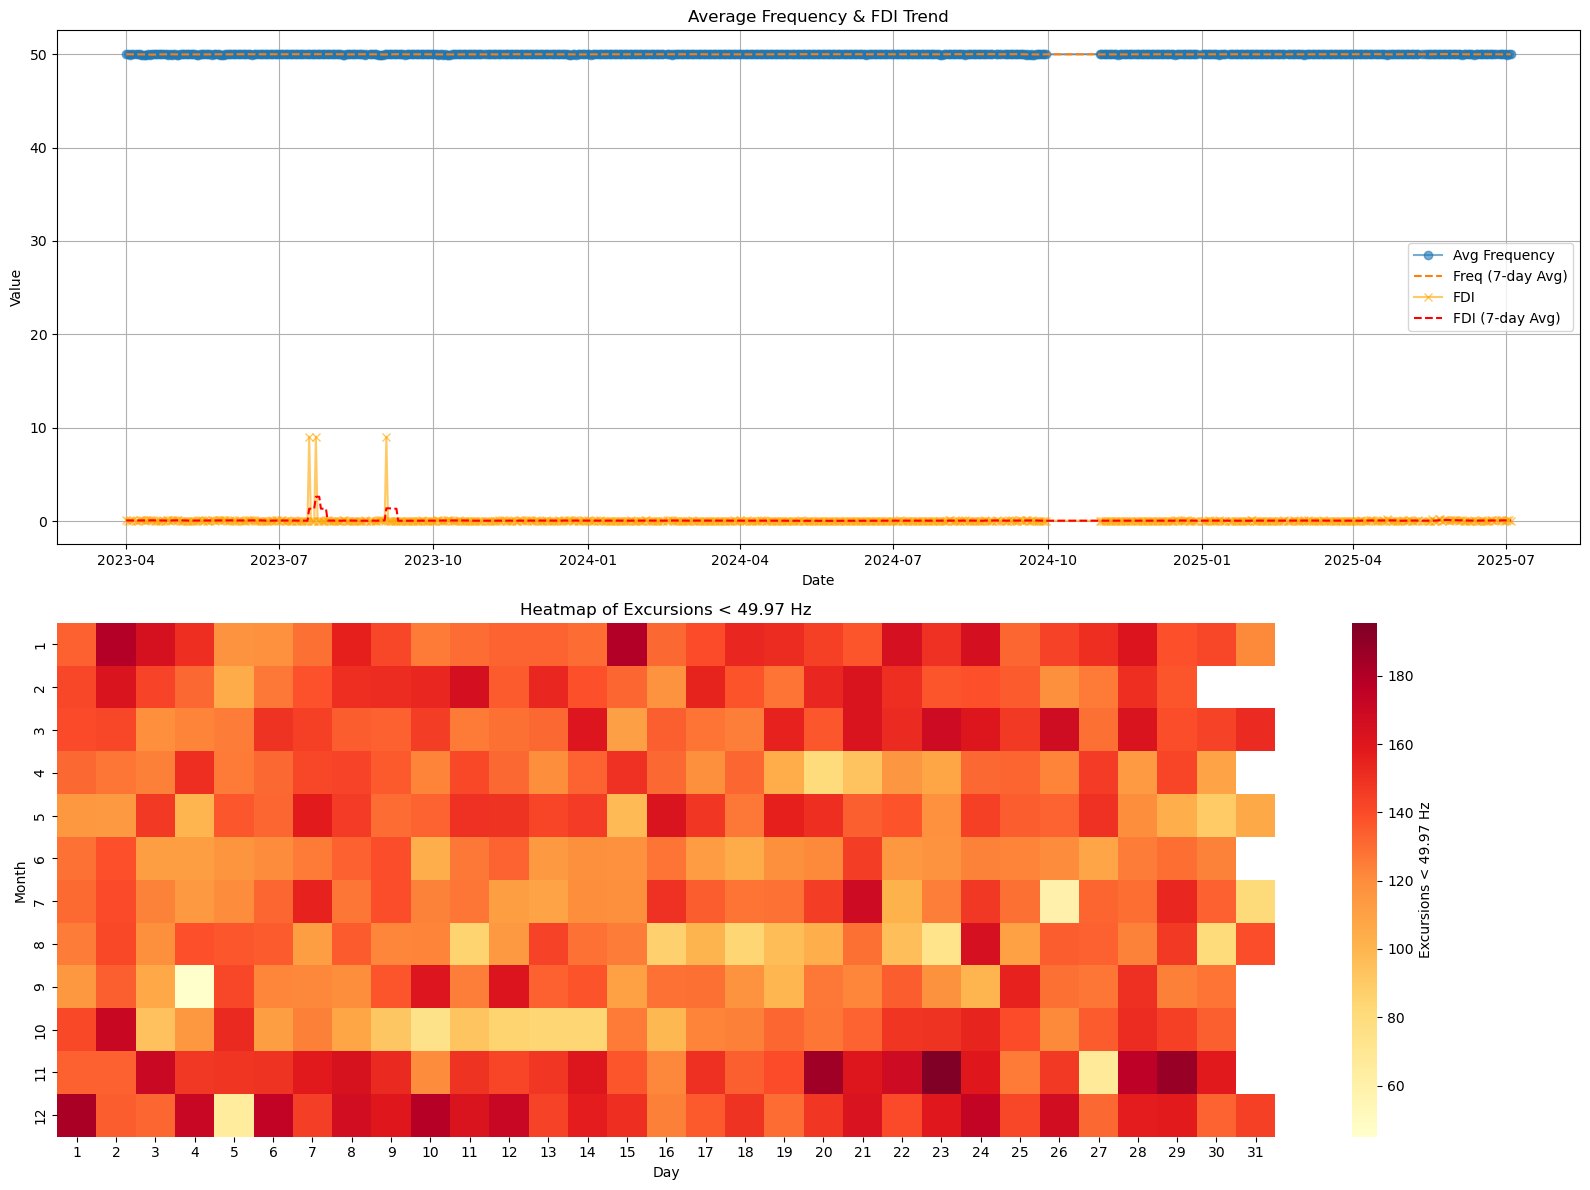

In [1]:
# 1. Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load & inspect
df = pd.read_csv('compiled_frequency_report.csv')
df.info()
df.head()

# 3. Clean & prepare
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)

# Fill numeric columns forward then backward
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].ffill().bfill()

# 4. Rolling averages
df['Freq_7d_avg'] = df['Average Frequency'].rolling(window=7, min_periods=1).mean()
df['FDI_7d_avg']  = df['FDI'].rolling(window=7, min_periods=1).mean()

# 5. Heatmap pivot
df['Month'] = df['Date'].dt.month
df['Day']   = df['Date'].dt.day
heatmap_data = df.pivot_table(
    index='Month', 
    columns='Day', 
    values='Excursions < 49.97 Hz'
)

# 6. Plotting
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 6a. Frequency & FDI trends
axes[0].plot(df['Date'], df['Average Frequency'], label='Avg Frequency', marker='o', alpha=0.6)
axes[0].plot(df['Date'], df['Freq_7d_avg'],       label='Freq (7-day Avg)', linestyle='--')
axes[0].plot(df['Date'], df['FDI'],               label='FDI', marker='x', alpha=0.6, color='orange')
axes[0].plot(df['Date'], df['FDI_7d_avg'],        label='FDI (7-day Avg)', linestyle='--', color='red')
axes[0].set_title('Average Frequency & FDI Trend')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True)

# 6b. Heatmap of excursions
sns.heatmap(heatmap_data, cmap='YlOrRd', ax=axes[1], cbar_kws={'label': 'Excursions < 49.97 Hz'})
axes[1].set_title('Heatmap of Excursions < 49.97 Hz')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Month')

plt.tight_layout()

# 7. Save high-res PNG
output_file = 'Frequency_FDI_Excursions_Report.png'
fig.savefig(output_file, dpi=300)
print(f'✔️ Saved figure to: {output_file}')

# 8. Display
plt.show()



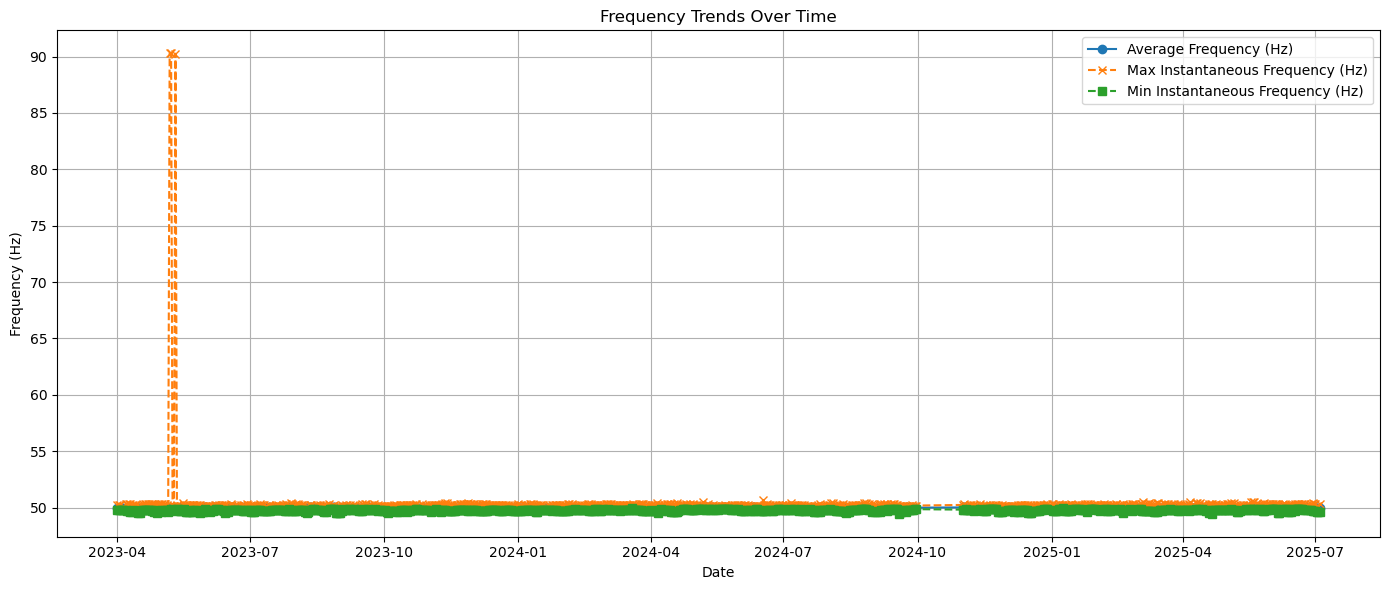

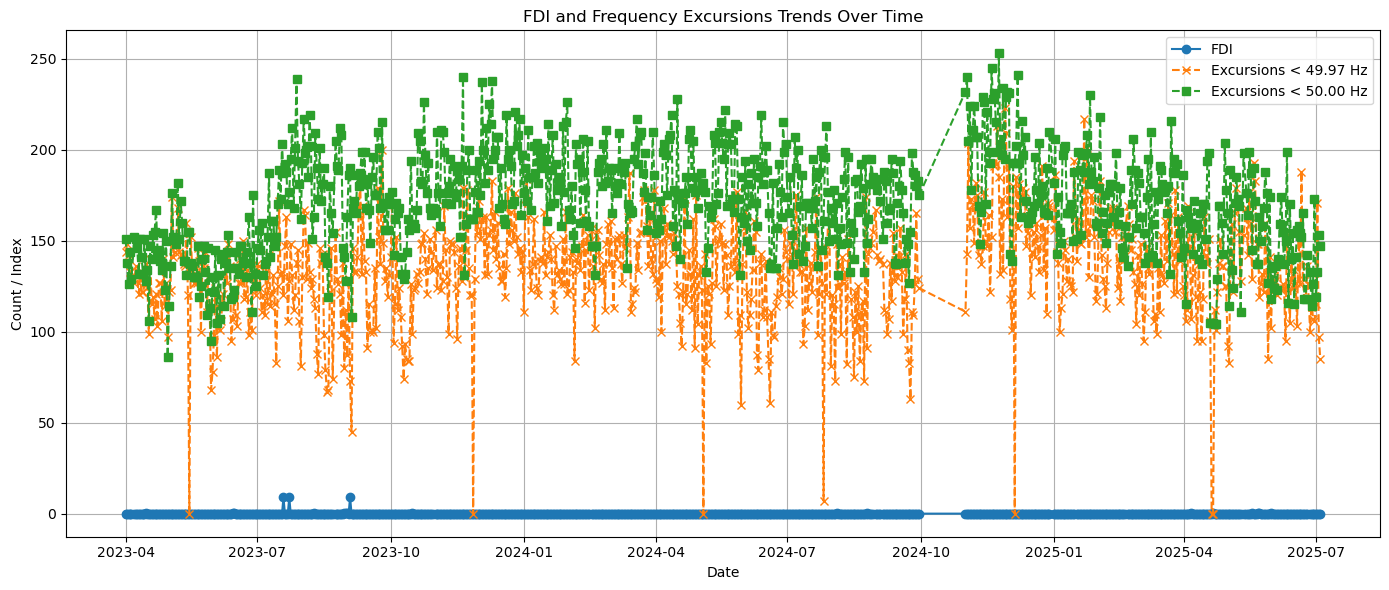

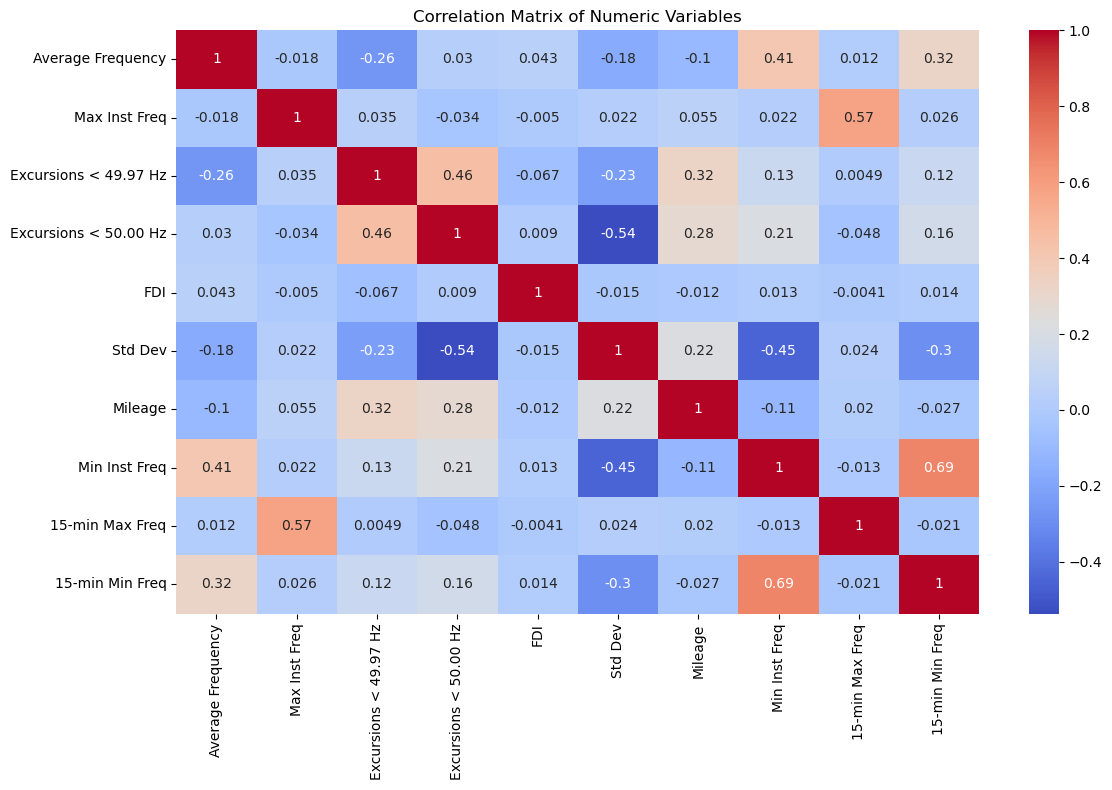

Outlier Dates based on Average Frequency Z-Score:
          Date  Average Frequency  AvgFreq_Z
11  2023-04-13             49.879  -7.693867
149 2023-08-30             49.950  -3.186857
150 2023-08-31             49.936  -4.075563
508 2024-08-25             50.065   4.113229
710 2025-04-21             49.938  -3.948605
735 2025-05-18             50.056   3.541918
739 2025-05-22             50.058   3.668876
✅ Cleaned dataset saved as 'cleaned_frequency_report.csv'


In [3]:
# ---------------------------------
# 📌 1. Import Libraries
# ---------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------
# 📌 2. Load the Data
# ---------------------------------
df = pd.read_csv('compiled_frequency_report.csv')

# ---------------------------------
# 📌 3. Convert Date & Sort
# ---------------------------------
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
df_sorted = df.sort_values(by='Date').reset_index(drop=True)

# ---------------------------------
# 📌 4. Handle Missing Values
# ---------------------------------
# Fill numeric columns
numeric_cols = df_sorted.select_dtypes(include=['float64', 'int64']).columns
df_sorted[numeric_cols] = df_sorted[numeric_cols].fillna(method='ffill').fillna(method='bfill')

# Fill time columns with 'Unknown'
time_cols = [col for col in df_sorted.columns if 'Time' in col]
df_sorted[time_cols] = df_sorted[time_cols].fillna('Unknown')

# ---------------------------------
# 📌 5. Plot Frequency Trends
# ---------------------------------
plt.figure(figsize=(14, 6))
plt.plot(df_sorted['Date'], df_sorted['Average Frequency'], marker='o', linestyle='-', label='Average Frequency (Hz)')
plt.plot(df_sorted['Date'], df_sorted['Max Inst Freq'], marker='x', linestyle='--', label='Max Instantaneous Frequency (Hz)')
plt.plot(df_sorted['Date'], df_sorted['Min Inst Freq'], marker='s', linestyle='--', label='Min Instantaneous Frequency (Hz)')
plt.title('Frequency Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------
# 📌 6. Plot FDI & Excursions
# ---------------------------------
plt.figure(figsize=(14, 6))
plt.plot(df_sorted['Date'], df_sorted['FDI'], marker='o', linestyle='-', label='FDI')
plt.plot(df_sorted['Date'], df_sorted['Excursions < 49.97 Hz'], marker='x', linestyle='--', label='Excursions < 49.97 Hz')
plt.plot(df_sorted['Date'], df_sorted['Excursions < 50.00 Hz'], marker='s', linestyle='--', label='Excursions < 50.00 Hz')
plt.title('FDI and Frequency Excursions Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Count / Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------
# 📌 7. Correlation Heatmap
# ---------------------------------
plt.figure(figsize=(12, 8))
corr = df_sorted[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show()

# ---------------------------------
# 📌 8. Outlier Detection: Z-Score Example
# ---------------------------------
from scipy.stats import zscore

# Calculate z-scores for Average Frequency
df_sorted['AvgFreq_Z'] = zscore(df_sorted['Average Frequency'])

# Flag as outliers if Z > 3 or < -3
outliers = df_sorted[(df_sorted['AvgFreq_Z'] > 3) | (df_sorted['AvgFreq_Z'] < -3)]
print("Outlier Dates based on Average Frequency Z-Score:")
print(outliers[['Date', 'Average Frequency', 'AvgFreq_Z']])

# ---------------------------------
# 📌 9. Save Cleaned Dataset
# ---------------------------------
df_sorted.to_csv('cleaned_frequency_report.csv', index=False)
print("✅ Cleaned dataset saved as 'cleaned_frequency_report.csv'")



✅ After removing outliers: 3 rows dropped.
Remaining rows: 779


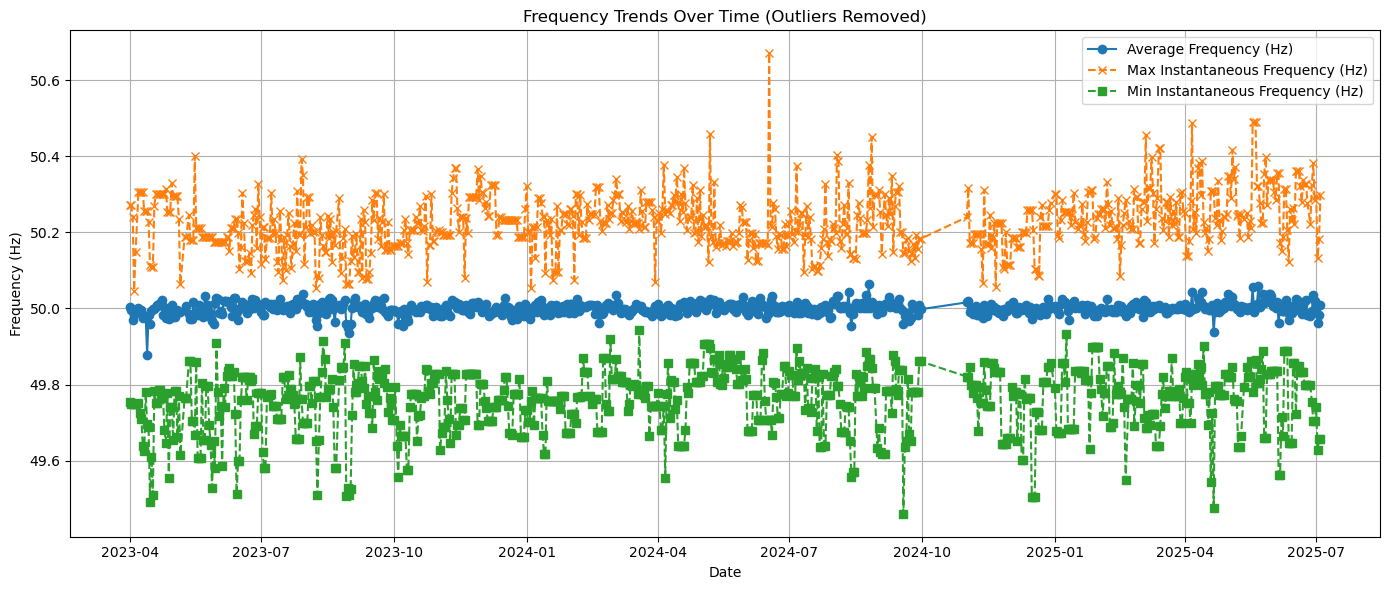

In [5]:
# ---------------------------------
# 📌 Extra Step: Remove Unrealistic Frequency Spikes
# ---------------------------------

# Define a reasonable threshold for your grid
# For example, anything above 52 Hz is highly unlikely
max_reasonable_freq = 52

# Remove rows with Max Inst Freq > threshold
df_cleaned = df_sorted[df_sorted['Max Inst Freq'] <= max_reasonable_freq].copy()

# Also, filter Min Inst Freq if needed (e.g., negative or absurd values)
df_cleaned = df_cleaned[df_cleaned['Min Inst Freq'] >= 48]

print(f"✅ After removing outliers: {len(df_sorted) - len(df_cleaned)} rows dropped.")
print(f"Remaining rows: {len(df_cleaned)}")

# Replot with cleaned data
plt.figure(figsize=(14, 6))
plt.plot(df_cleaned['Date'], df_cleaned['Average Frequency'], marker='o', linestyle='-', label='Average Frequency (Hz)')
plt.plot(df_cleaned['Date'], df_cleaned['Max Inst Freq'], marker='x', linestyle='--', label='Max Instantaneous Frequency (Hz)')
plt.plot(df_cleaned['Date'], df_cleaned['Min Inst Freq'], marker='s', linestyle='--', label='Min Instantaneous Frequency (Hz)')
plt.title('Frequency Trends Over Time (Outliers Removed)')
plt.xlabel('Date')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()






In [6]:
# …after plotting…
out = 'frequency_fdi_excursions_dashboard.png'
fig.savefig(out, dpi=300)
print(f"✅ Saved dashboard to: {out}")




✅ Saved dashboard to: frequency_fdi_excursions_dashboard.png


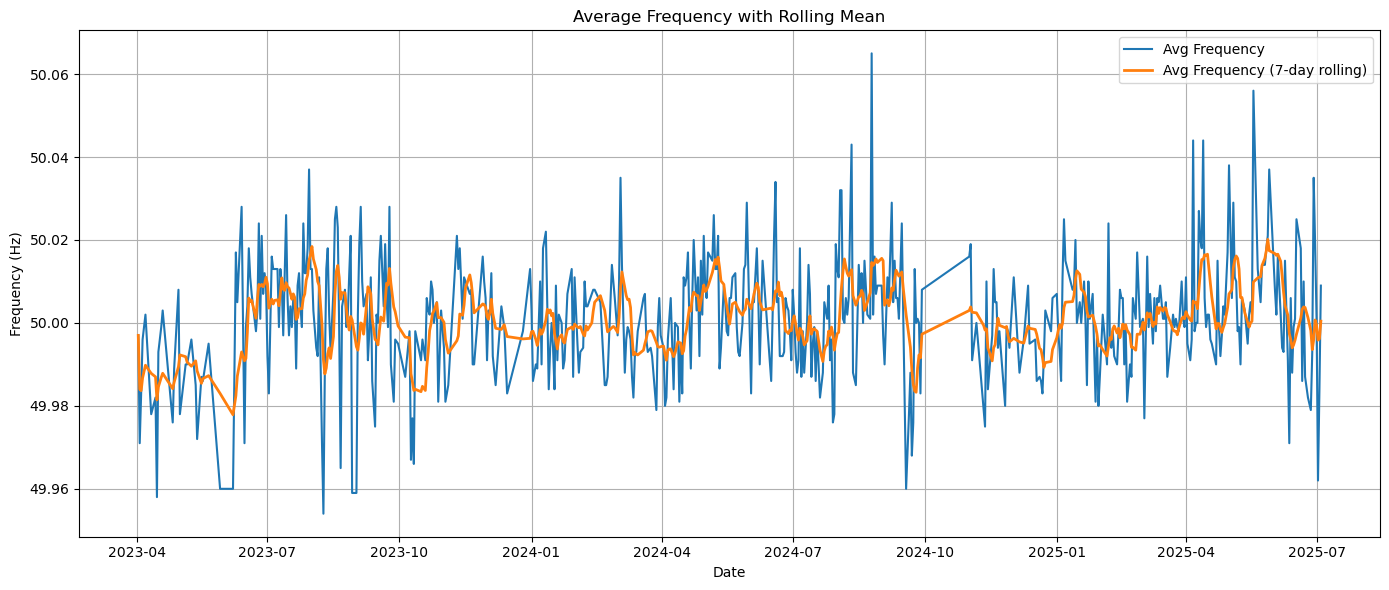

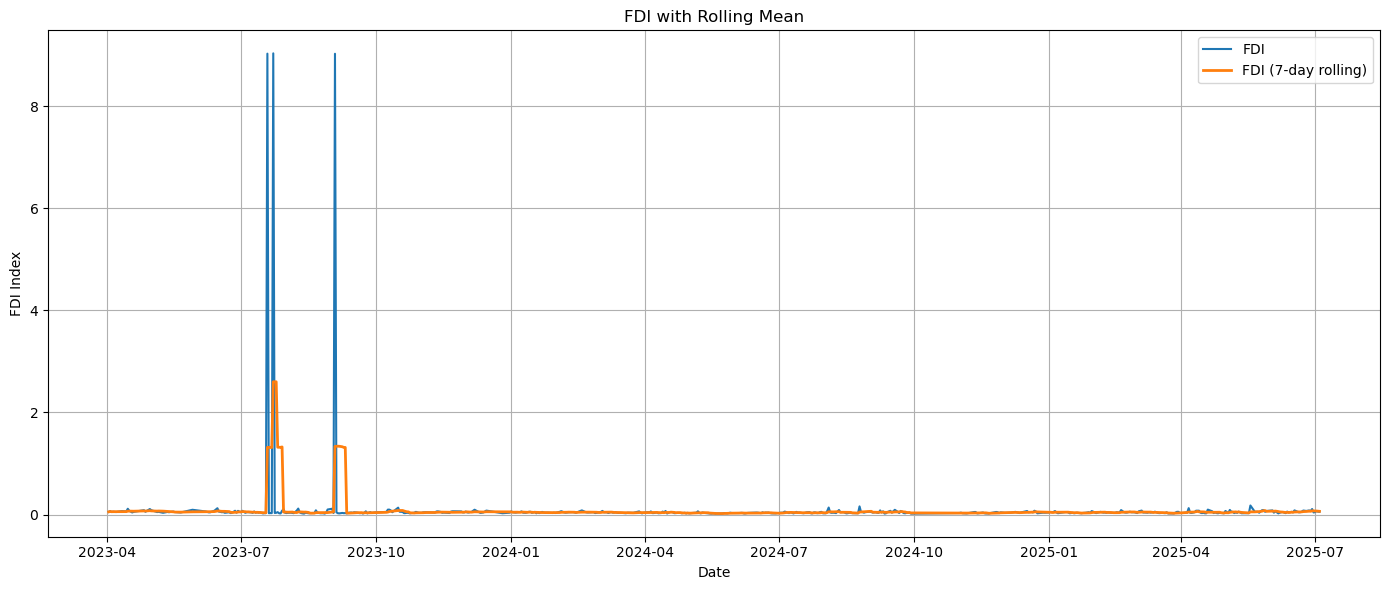

✅ Final profiled data saved as 'final_cleaned_freq_profile.csv'


In [7]:
# ---------------------------------------
# 📌 1. Import libraries
# ---------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------
# 📌 2. Load data (already cleaned version)
# ---------------------------------------
df = pd.read_csv('compiled_frequency_report.csv')

# Convert date & sort
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
df_sorted = df.sort_values(by='Date').reset_index(drop=True)

# Remove unrealistic outliers (Max Inst Freq > 52 Hz)
df_sorted = df_sorted[df_sorted['Max Inst Freq'] <= 52].copy()

# Fill missing numeric values
numeric_cols = df_sorted.select_dtypes(include=['float64', 'int64']).columns
df_sorted[numeric_cols] = df_sorted[numeric_cols].fillna(method='ffill').fillna(method='bfill')

# Fill time columns with 'Unknown'
time_cols = [col for col in df_sorted.columns if 'Time' in col]
df_sorted[time_cols] = df_sorted[time_cols].fillna('Unknown')

# ---------------------------------------
# 📌 3. Add Rolling Averages (7-day window)
# ---------------------------------------
df_sorted['AvgFreq_Roll'] = df_sorted['Average Frequency'].rolling(window=7, min_periods=1).mean()
df_sorted['FDI_Roll'] = df_sorted['FDI'].rolling(window=7, min_periods=1).mean()
df_sorted['Excursions_49.97_Roll'] = df_sorted['Excursions < 49.97 Hz'].rolling(window=7, min_periods=1).mean()
df_sorted['Excursions_50_Roll'] = df_sorted['Excursions < 50.00 Hz'].rolling(window=7, min_periods=1).mean()

# ---------------------------------------
# 📌 4. Recompute FDI (Example - normalized Std Dev)
# ---------------------------------------
# Simple version: use normalized Std Dev as FDI
df_sorted['FDI_Recomputed'] = df_sorted['Std Dev'] / df_sorted['Average Frequency']

# ---------------------------------------
# 📌 5. Plot with Rolling Averages
# ---------------------------------------

plt.figure(figsize=(14, 6))
plt.plot(df_sorted['Date'], df_sorted['Average Frequency'], label='Avg Frequency')
plt.plot(df_sorted['Date'], df_sorted['AvgFreq_Roll'], label='Avg Frequency (7-day rolling)', linewidth=2)
plt.title('Average Frequency with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(df_sorted['Date'], df_sorted['FDI'], label='FDI')
plt.plot(df_sorted['Date'], df_sorted['FDI_Roll'], label='FDI (7-day rolling)', linewidth=2)
plt.title('FDI with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('FDI Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------
# 📌 6. Save Cleaned & Profiled Data
# ---------------------------------------
export_cols = [
    'Date', 
    'Average Frequency', 'AvgFreq_Roll',
    'Max Inst Freq', 'Min Inst Freq',
    'FDI', 'FDI_Roll', 'FDI_Recomputed',
    'Excursions < 49.97 Hz', 'Excursions_49.97_Roll',
    'Excursions < 50.00 Hz', 'Excursions_50_Roll'
]

df_sorted[export_cols].to_csv('final_cleaned_freq_profile.csv', index=False)
print("✅ Final profiled data saved as 'final_cleaned_freq_profile.csv'")



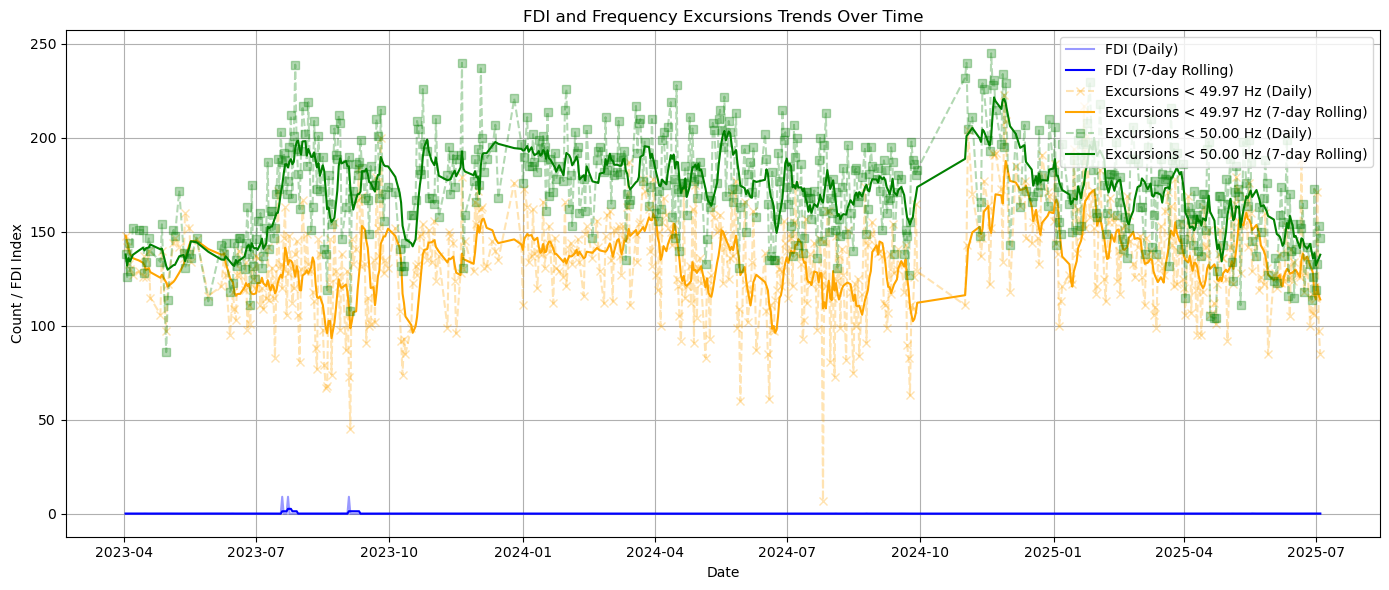

In [8]:
# -------------------------------------------------
# 📌 1. Import Libraries
# -------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# 📌 2. Load Final Cleaned Data (if not already loaded)
# -------------------------------------------------
df = pd.read_csv('final_cleaned_freq_profile.csv')
df['Date'] = pd.to_datetime(df['Date'])

# -------------------------------------------------
# 📌 3. Plot FDI & Excursions with Rolling Means
# -------------------------------------------------

plt.figure(figsize=(14, 6))

# Raw FDI
plt.plot(df['Date'], df['FDI'], color='blue', alpha=0.4, label='FDI (Daily)')
plt.plot(df['Date'], df['FDI_Roll'], color='blue', linestyle='-', label='FDI (7-day Rolling)')

# Excursions < 49.97 Hz
plt.plot(df['Date'], df['Excursions < 49.97 Hz'], marker='x', color='orange', alpha=0.3, linestyle='--', label='Excursions < 49.97 Hz (Daily)')
plt.plot(df['Date'], df['Excursions_49.97_Roll'], color='orange', linestyle='-', label='Excursions < 49.97 Hz (7-day Rolling)')

# Excursions < 50.00 Hz
plt.plot(df['Date'], df['Excursions < 50.00 Hz'], marker='s', color='green', alpha=0.3, linestyle='--', label='Excursions < 50.00 Hz (Daily)')
plt.plot(df['Date'], df['Excursions_50_Roll'], color='green', linestyle='-', label='Excursions < 50.00 Hz (7-day Rolling)')

# -------------------------------------------------
# 📌 4. Add Title, Labels, and Grid
# -------------------------------------------------
plt.title('FDI and Frequency Excursions Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Count / FDI Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [9]:
# Add a flag for high FDI days
FDI_threshold = 0.05  # Adjust this to your grid standard
df_sorted['Inertia_Shortfall'] = df_sorted['FDI'] > FDI_threshold

# Count how many days need synthetic inertia
shortfall_days = df_sorted[df_sorted['Inertia_Shortfall']]
print(f"Number of days with FDI > {FDI_threshold}: {len(shortfall_days)}")

# Save only shortfall periods for MATLAB
shortfall_days.to_csv('inertia_shortfall_days.csv', index=False)
print("✅ Inertia shortfall periods exported for further simulation")




Number of days with FDI > 0.05: 143
✅ Inertia shortfall periods exported for further simulation


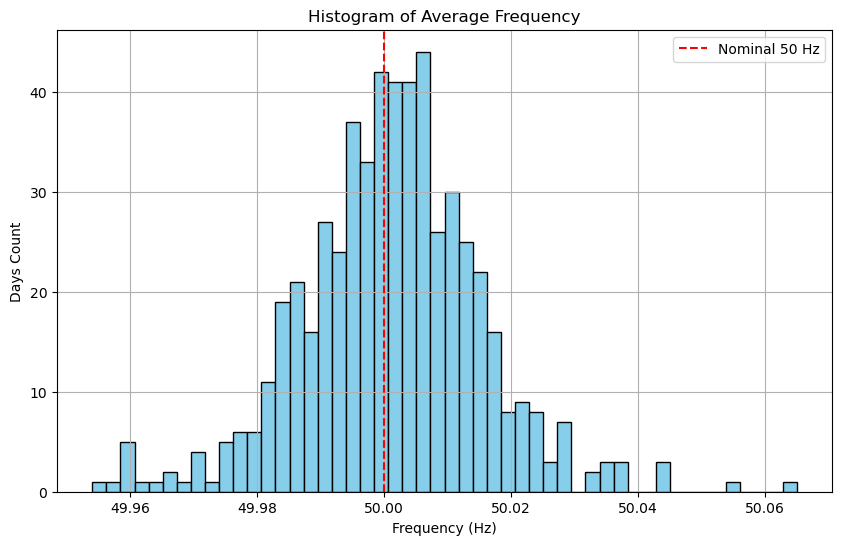

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df_sorted['Average Frequency'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Average Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Days Count')
plt.axvline(50, color='red', linestyle='--', label='Nominal 50 Hz')
plt.legend()
plt.grid(True)
plt.show()


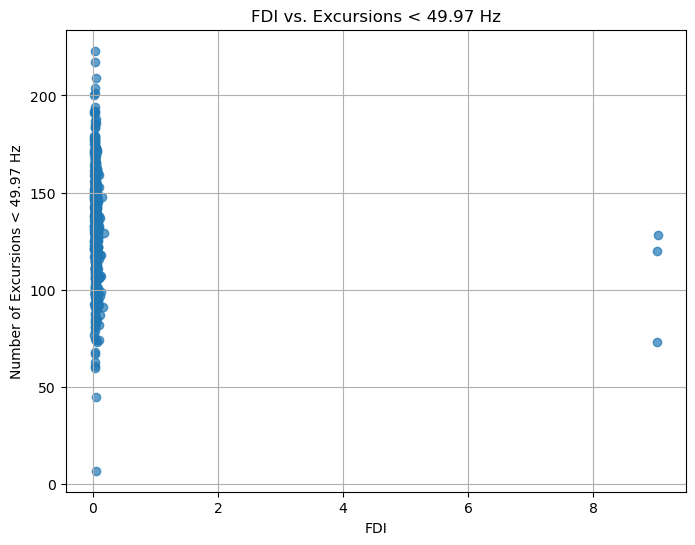

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(df_sorted['FDI'], df_sorted['Excursions < 49.97 Hz'], alpha=0.7)
plt.title('FDI vs. Excursions < 49.97 Hz')
plt.xlabel('FDI')
plt.ylabel('Number of Excursions < 49.97 Hz')
plt.grid(True)
plt.show()



<Figure size 1200x600 with 0 Axes>

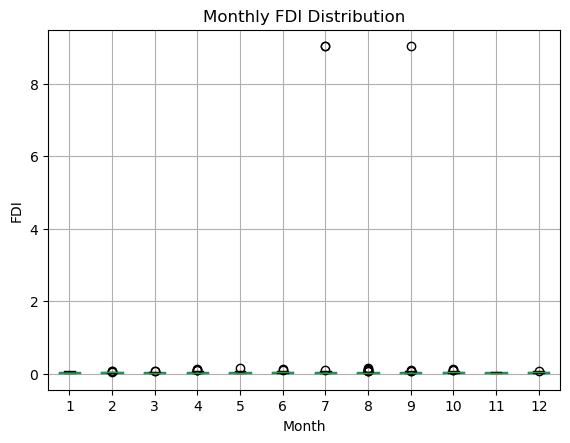

In [12]:
df_sorted['Month'] = df_sorted['Date'].dt.month
plt.figure(figsize=(12,6))
df_sorted.boxplot(column='FDI', by='Month', grid=True)
plt.title('Monthly FDI Distribution')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('FDI')
plt.show()



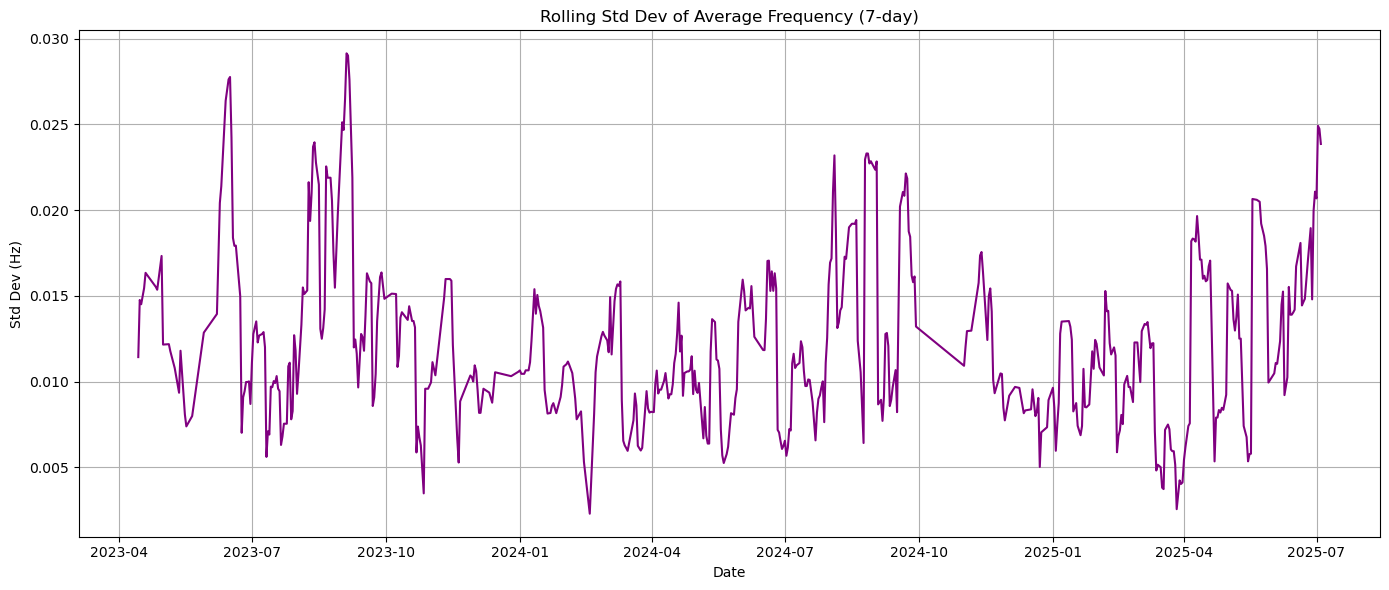

In [13]:
df_sorted['Freq_StdDev_Roll'] = df_sorted['Average Frequency'].rolling(window=7).std()

plt.figure(figsize=(14,6))
plt.plot(df_sorted['Date'], df_sorted['Freq_StdDev_Roll'], color='purple')
plt.title('Rolling Std Dev of Average Frequency (7-day)')
plt.xlabel('Date')
plt.ylabel('Std Dev (Hz)')
plt.grid(True)
plt.tight_layout()
plt.show()


(array([0.]), [Text(0.0, 0, 'Jan 1970')])

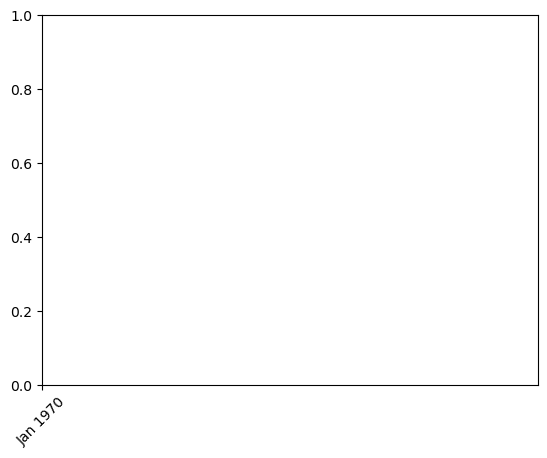

In [9]:
import matplotlib.dates as mdates

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


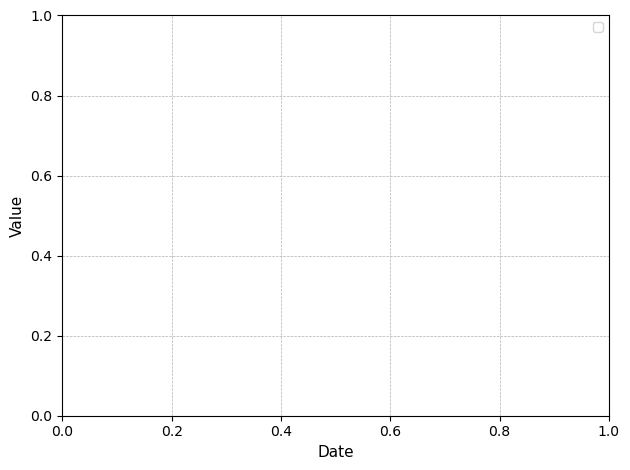

In [10]:
plt.xlabel("Date", fontsize=11)
plt.ylabel("Value", fontsize=11)
plt.legend(loc='upper right', fontsize=9)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("FDI_Frequency_1Year_Q1.png", dpi=300)


C:\Users\rjesh\AppData\Local\Temp\ipykernel_12656\373375116.py:14: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)


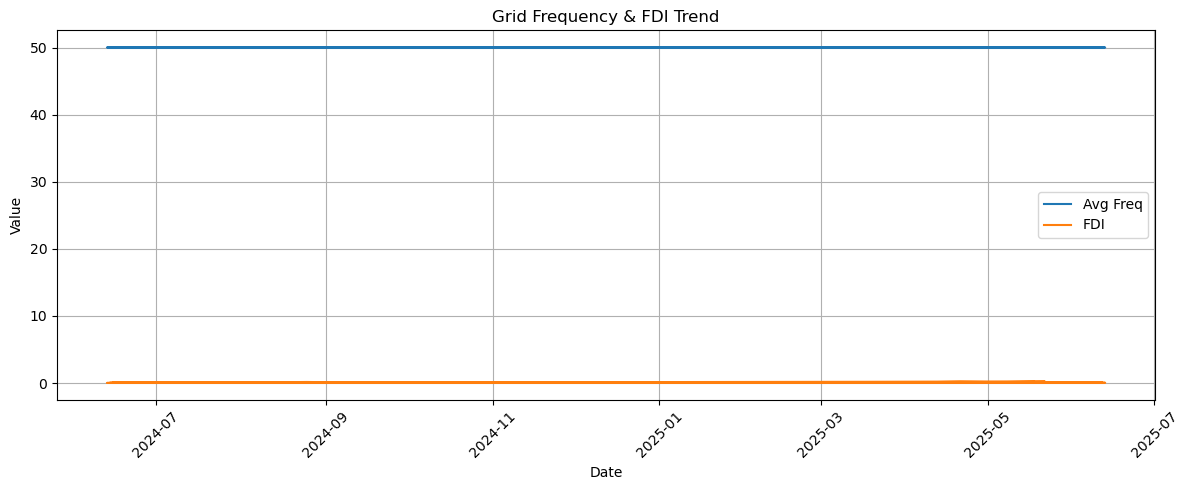

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['average frequency'], label='Avg Freq')
plt.plot(df['date'], df['fdi'], label='FDI')

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Grid Frequency & FDI Trend")
plt.legend()

plt.xticks(rotation=45)
plt.locator_params(axis='x', nbins=10)

plt.tight_layout()
plt.grid(True)
plt.show()


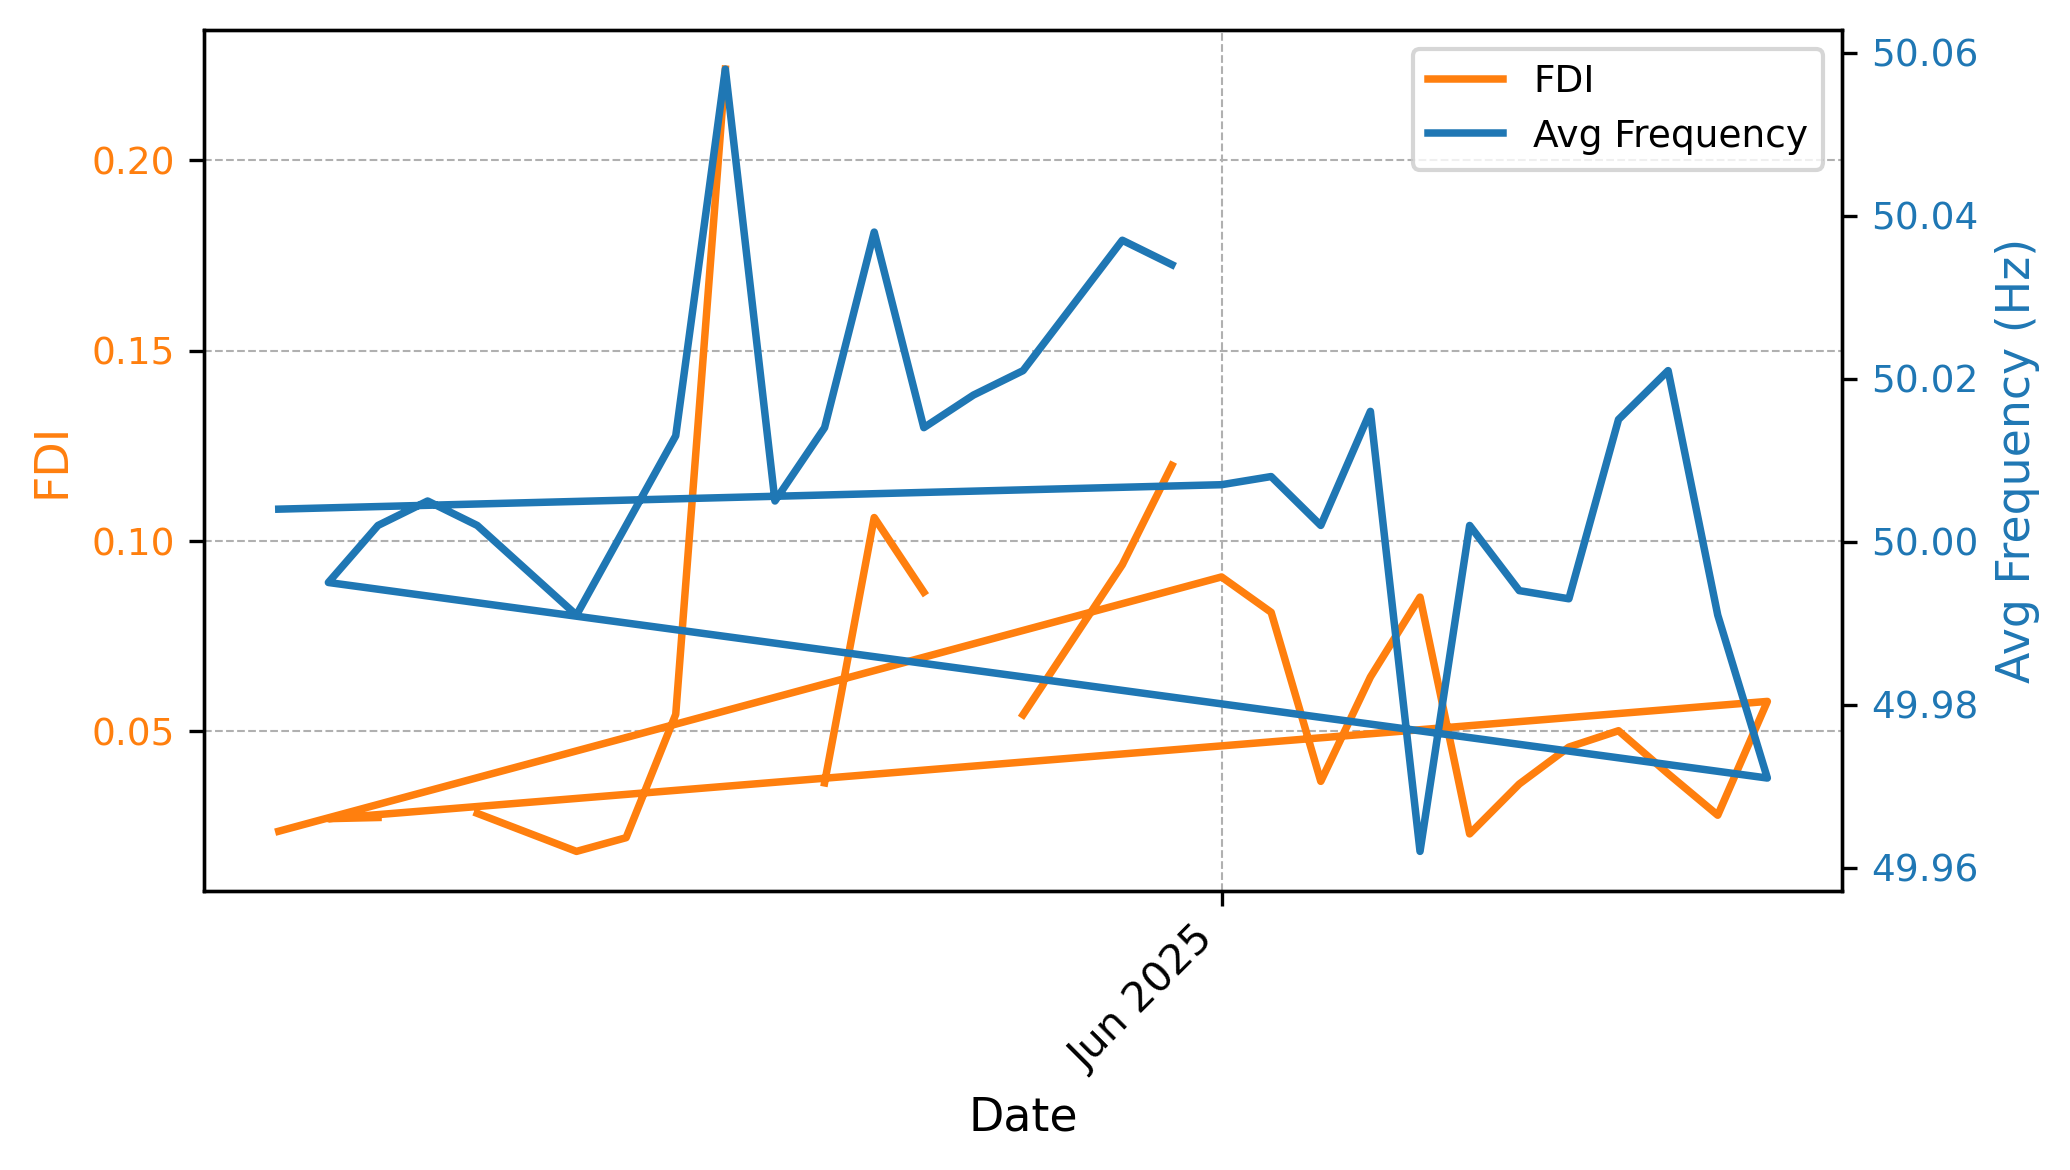

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ✅ Load your dataset
df = pd.read_csv("simulation_input_matlab.csv")
df.columns = df.columns.str.strip().str.lower()
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# ✅ Create the figure and dual y-axis
fig, ax1 = plt.subplots(figsize=(7, 4), dpi=300)

# 🔸 Left Y-axis: FDI
ax1.plot(df['date'], df['fdi'], color='tab:orange', label='FDI', linewidth=1.8)
ax1.set_ylabel("FDI", color='tab:orange', fontsize=11)
ax1.tick_params(axis='y', labelcolor='tab:orange', labelsize=9)

# 🔹 Right Y-axis: Average Frequency
ax2 = ax1.twinx()
ax2.plot(df['date'], df['average frequency'], color='tab:blue', label='Avg Frequency', linewidth=1.8)
ax2.set_ylabel("Avg Frequency (Hz)", color='tab:blue', fontsize=11)
ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=9)

# 📅 Format X-axis for monthly ticks
ax1.set_xlabel("Date", fontsize=11)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=45)

# 🧾 Legend (merged from both axes)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=9)

# 🧱 Grid and layout
ax1.grid(True, linestyle='--', linewidth=0.5)
fig.tight_layout()

# 💾 Save high-resolution figure
plt.savefig("FDI_vs_Frequency_1Year_Q1.png", dpi=300)

# 📈 Show
plt.show()


C:\Users\rjesh\AppData\Local\Temp\ipykernel_12656\1019523068.py:69: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\rjesh\AppData\Local\Temp\ipykernel_12656\1019523068.py:70: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  plt.savefig("Power_Grid_Dashboard.png", dpi=300)
C:\Users\rjesh\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


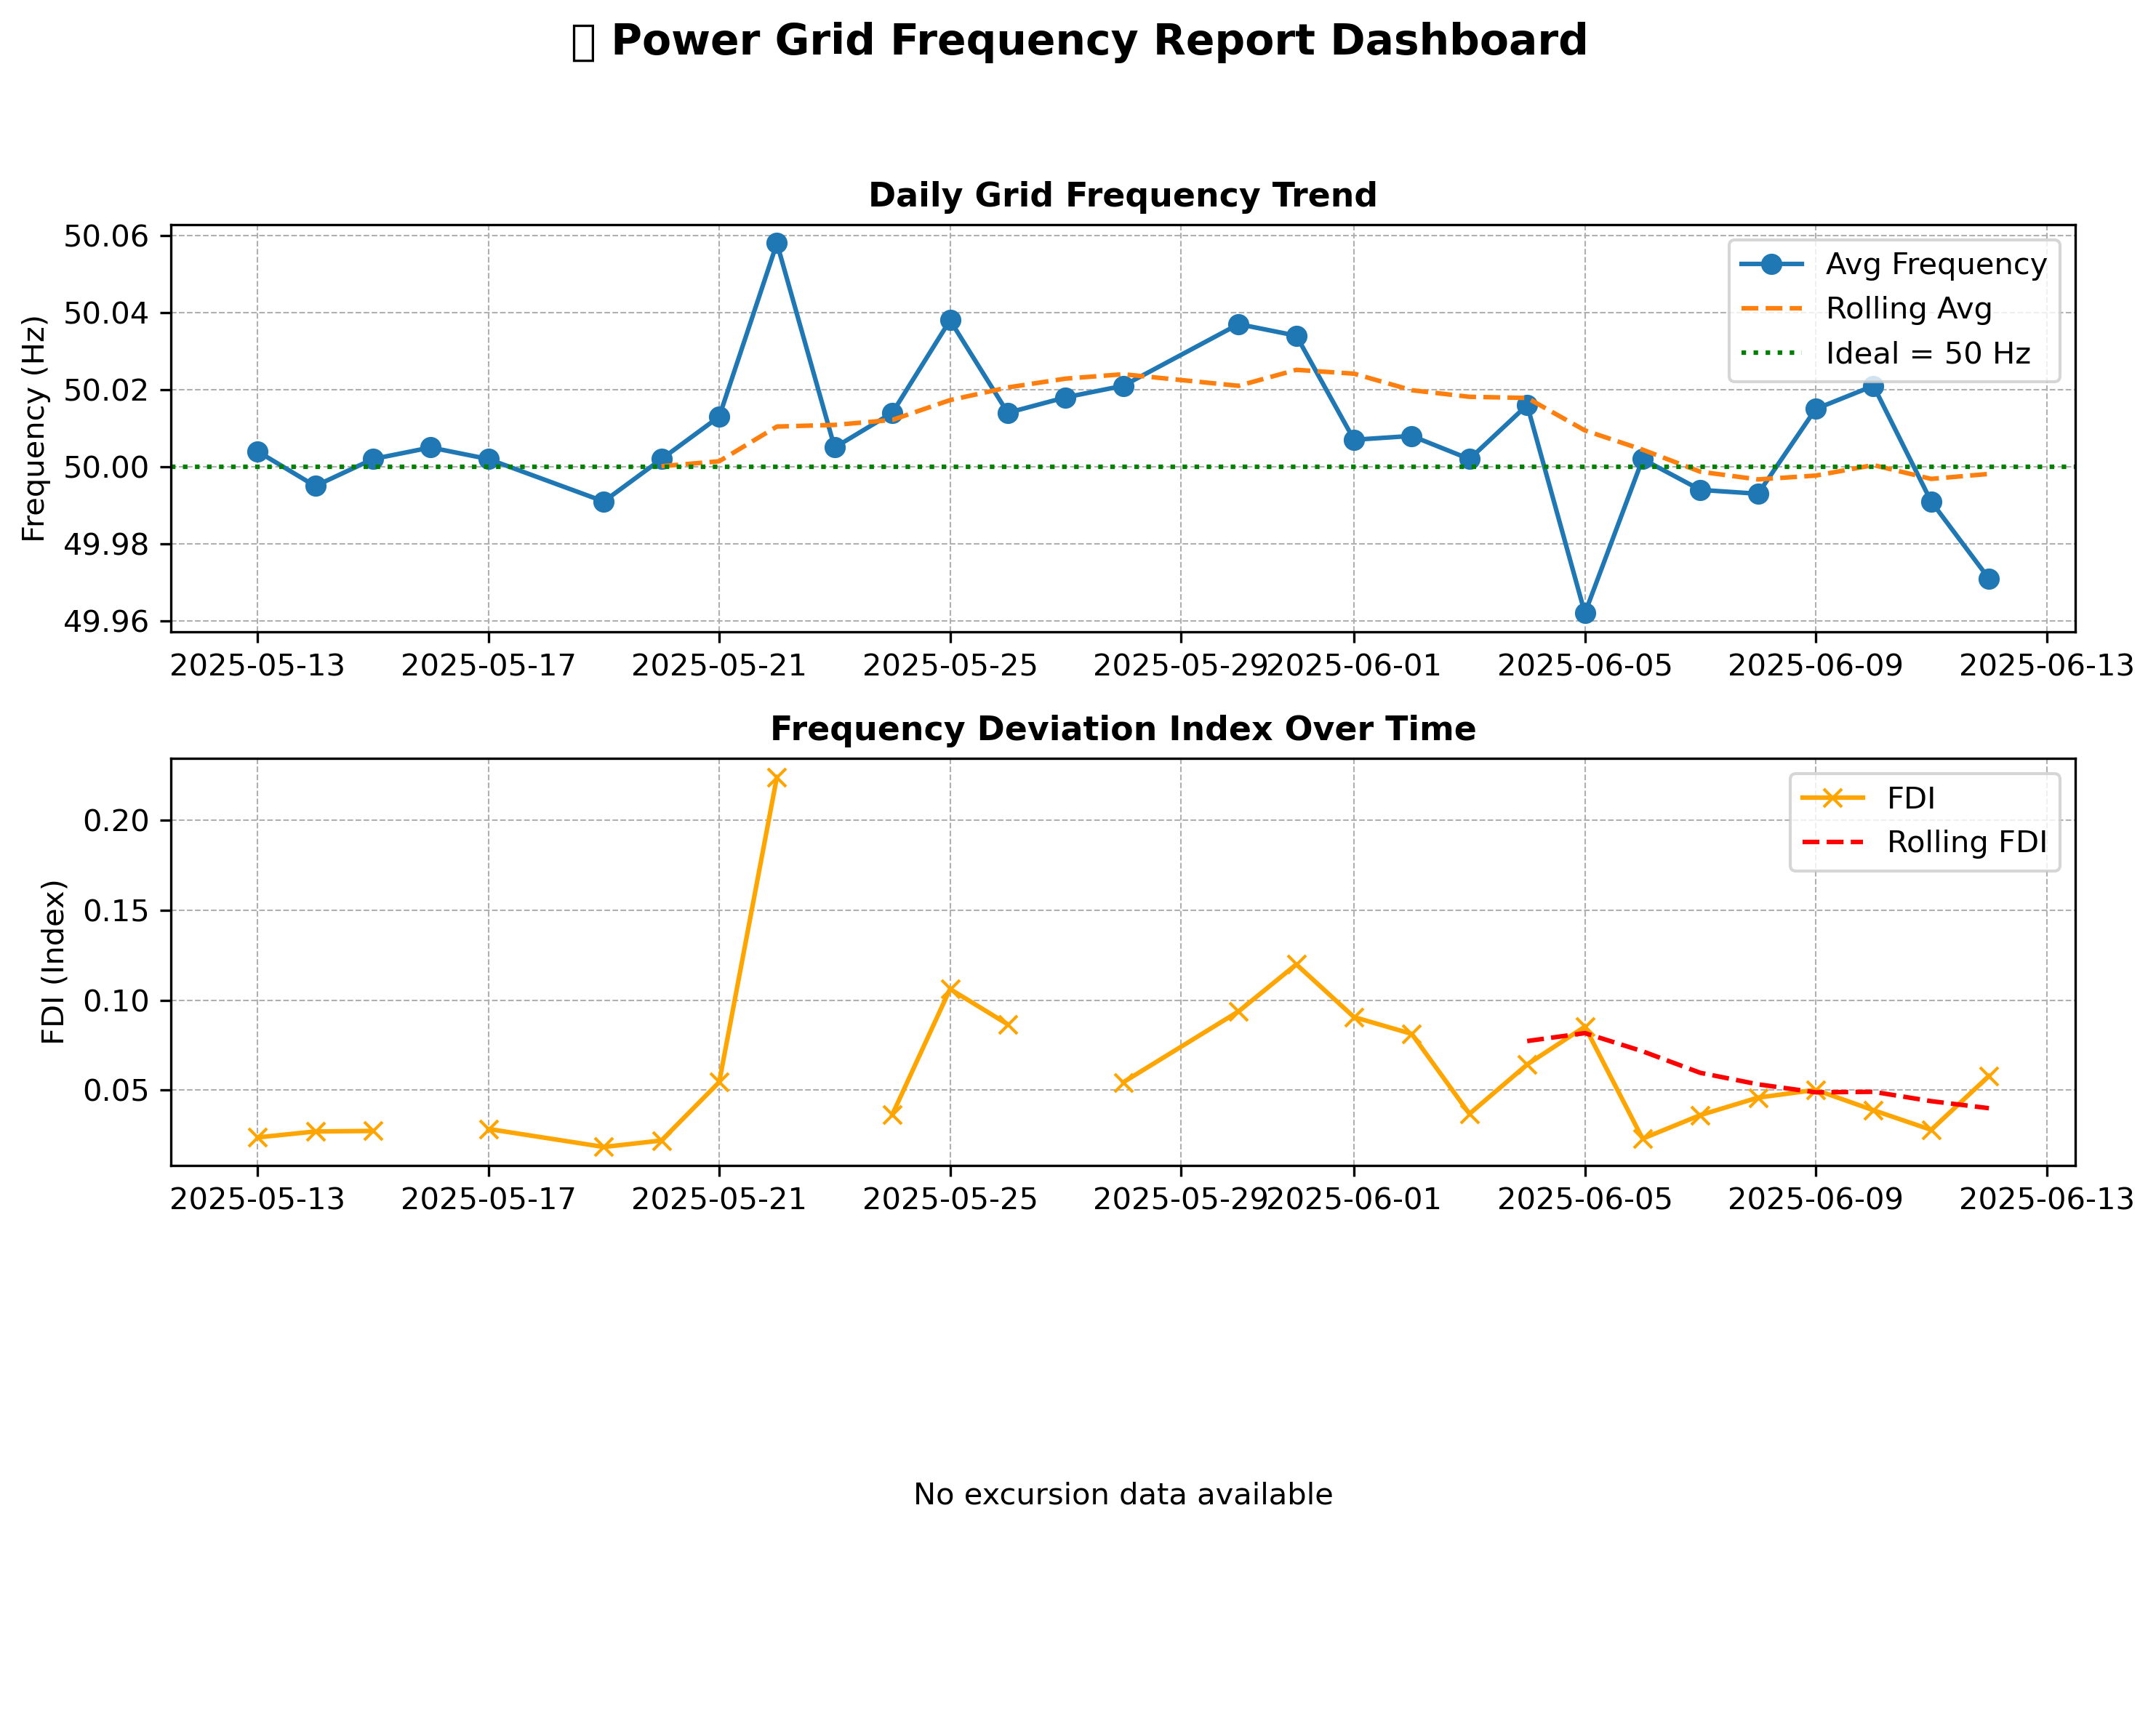

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# --------------------------------------
# 📊 Load your merged dataset
# --------------------------------------
df = pd.read_csv("simulation_input_matlab.csv")
df.columns = df.columns.str.strip().str.lower()
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Optional: sort for clean plotting
df = df.sort_values(by='date')

# --------------------------------------
# ➕ Rolling Averages (7-day window)
# --------------------------------------
df['rolling_avg_freq'] = df['average frequency'].rolling(window=7).mean()
df['rolling_fdi'] = df['fdi'].rolling(window=7).mean()

# --------------------------------------
# 🎨 Set up 3-row subplot layout
# --------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(10, 8), dpi=300)
fig.suptitle("🧭 Power Grid Frequency Report Dashboard", fontsize=14, weight='bold')

# --------------------------------------
# 📈 Plot 1: Frequency Trend
# --------------------------------------
axs[0].plot(df['date'], df['average frequency'], marker='o', label='Avg Frequency')
axs[0].plot(df['date'], df['rolling_avg_freq'], linestyle='--', label='Rolling Avg')
axs[0].axhline(50.00, color='green', linestyle=':', label='Ideal = 50 Hz')
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Daily Grid Frequency Trend", fontsize=11, weight='bold')
axs[0].legend()
axs[0].grid(True, linestyle='--', linewidth=0.5)

# --------------------------------------
# 📉 Plot 2: FDI Over Time
# --------------------------------------
axs[1].plot(df['date'], df['fdi'], marker='x', label='FDI', color='orange')
axs[1].plot(df['date'], df['rolling_fdi'], linestyle='--', label='Rolling FDI', color='red')
axs[1].set_ylabel("FDI (Index)")
axs[1].set_title("Frequency Deviation Index Over Time", fontsize=11, weight='bold')
axs[1].legend()
axs[1].grid(True, linestyle='--', linewidth=0.5)

# --------------------------------------
# 🔥 Plot 3: Heatmap of Excursions < 49.97 Hz
# --------------------------------------
# NOTE: Replace with actual excursion count column if you have it
# Example placeholder (synthetic values): df['excursions_4997'] = ...
if 'excursions < 49.97 hz' in df.columns:
    excursions_data = df[['date', 'excursions < 49.97 hz']].dropna()
    heatmap_data = excursions_data.set_index('date').T
    sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='.0f', ax=axs[2], cbar=True)
    axs[2].set_title("🔥 Excursions < 49.97 Hz (Heatmap)", fontsize=11, weight='bold')
    axs[2].set_yticklabels(['excursions'], rotation=0)
    axs[2].set_xlabel("date")
    axs[2].tick_params(axis='x', labelrotation=45)
else:
    axs[2].text(0.5, 0.5, "No excursion data available", ha='center', va='center')
    axs[2].axis('off')

# --------------------------------------
# 🎯 Final Touches
# --------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Power_Grid_Dashboard.png", dpi=300)
plt.show()


⚠️ Adding simulated excursion data for demo.


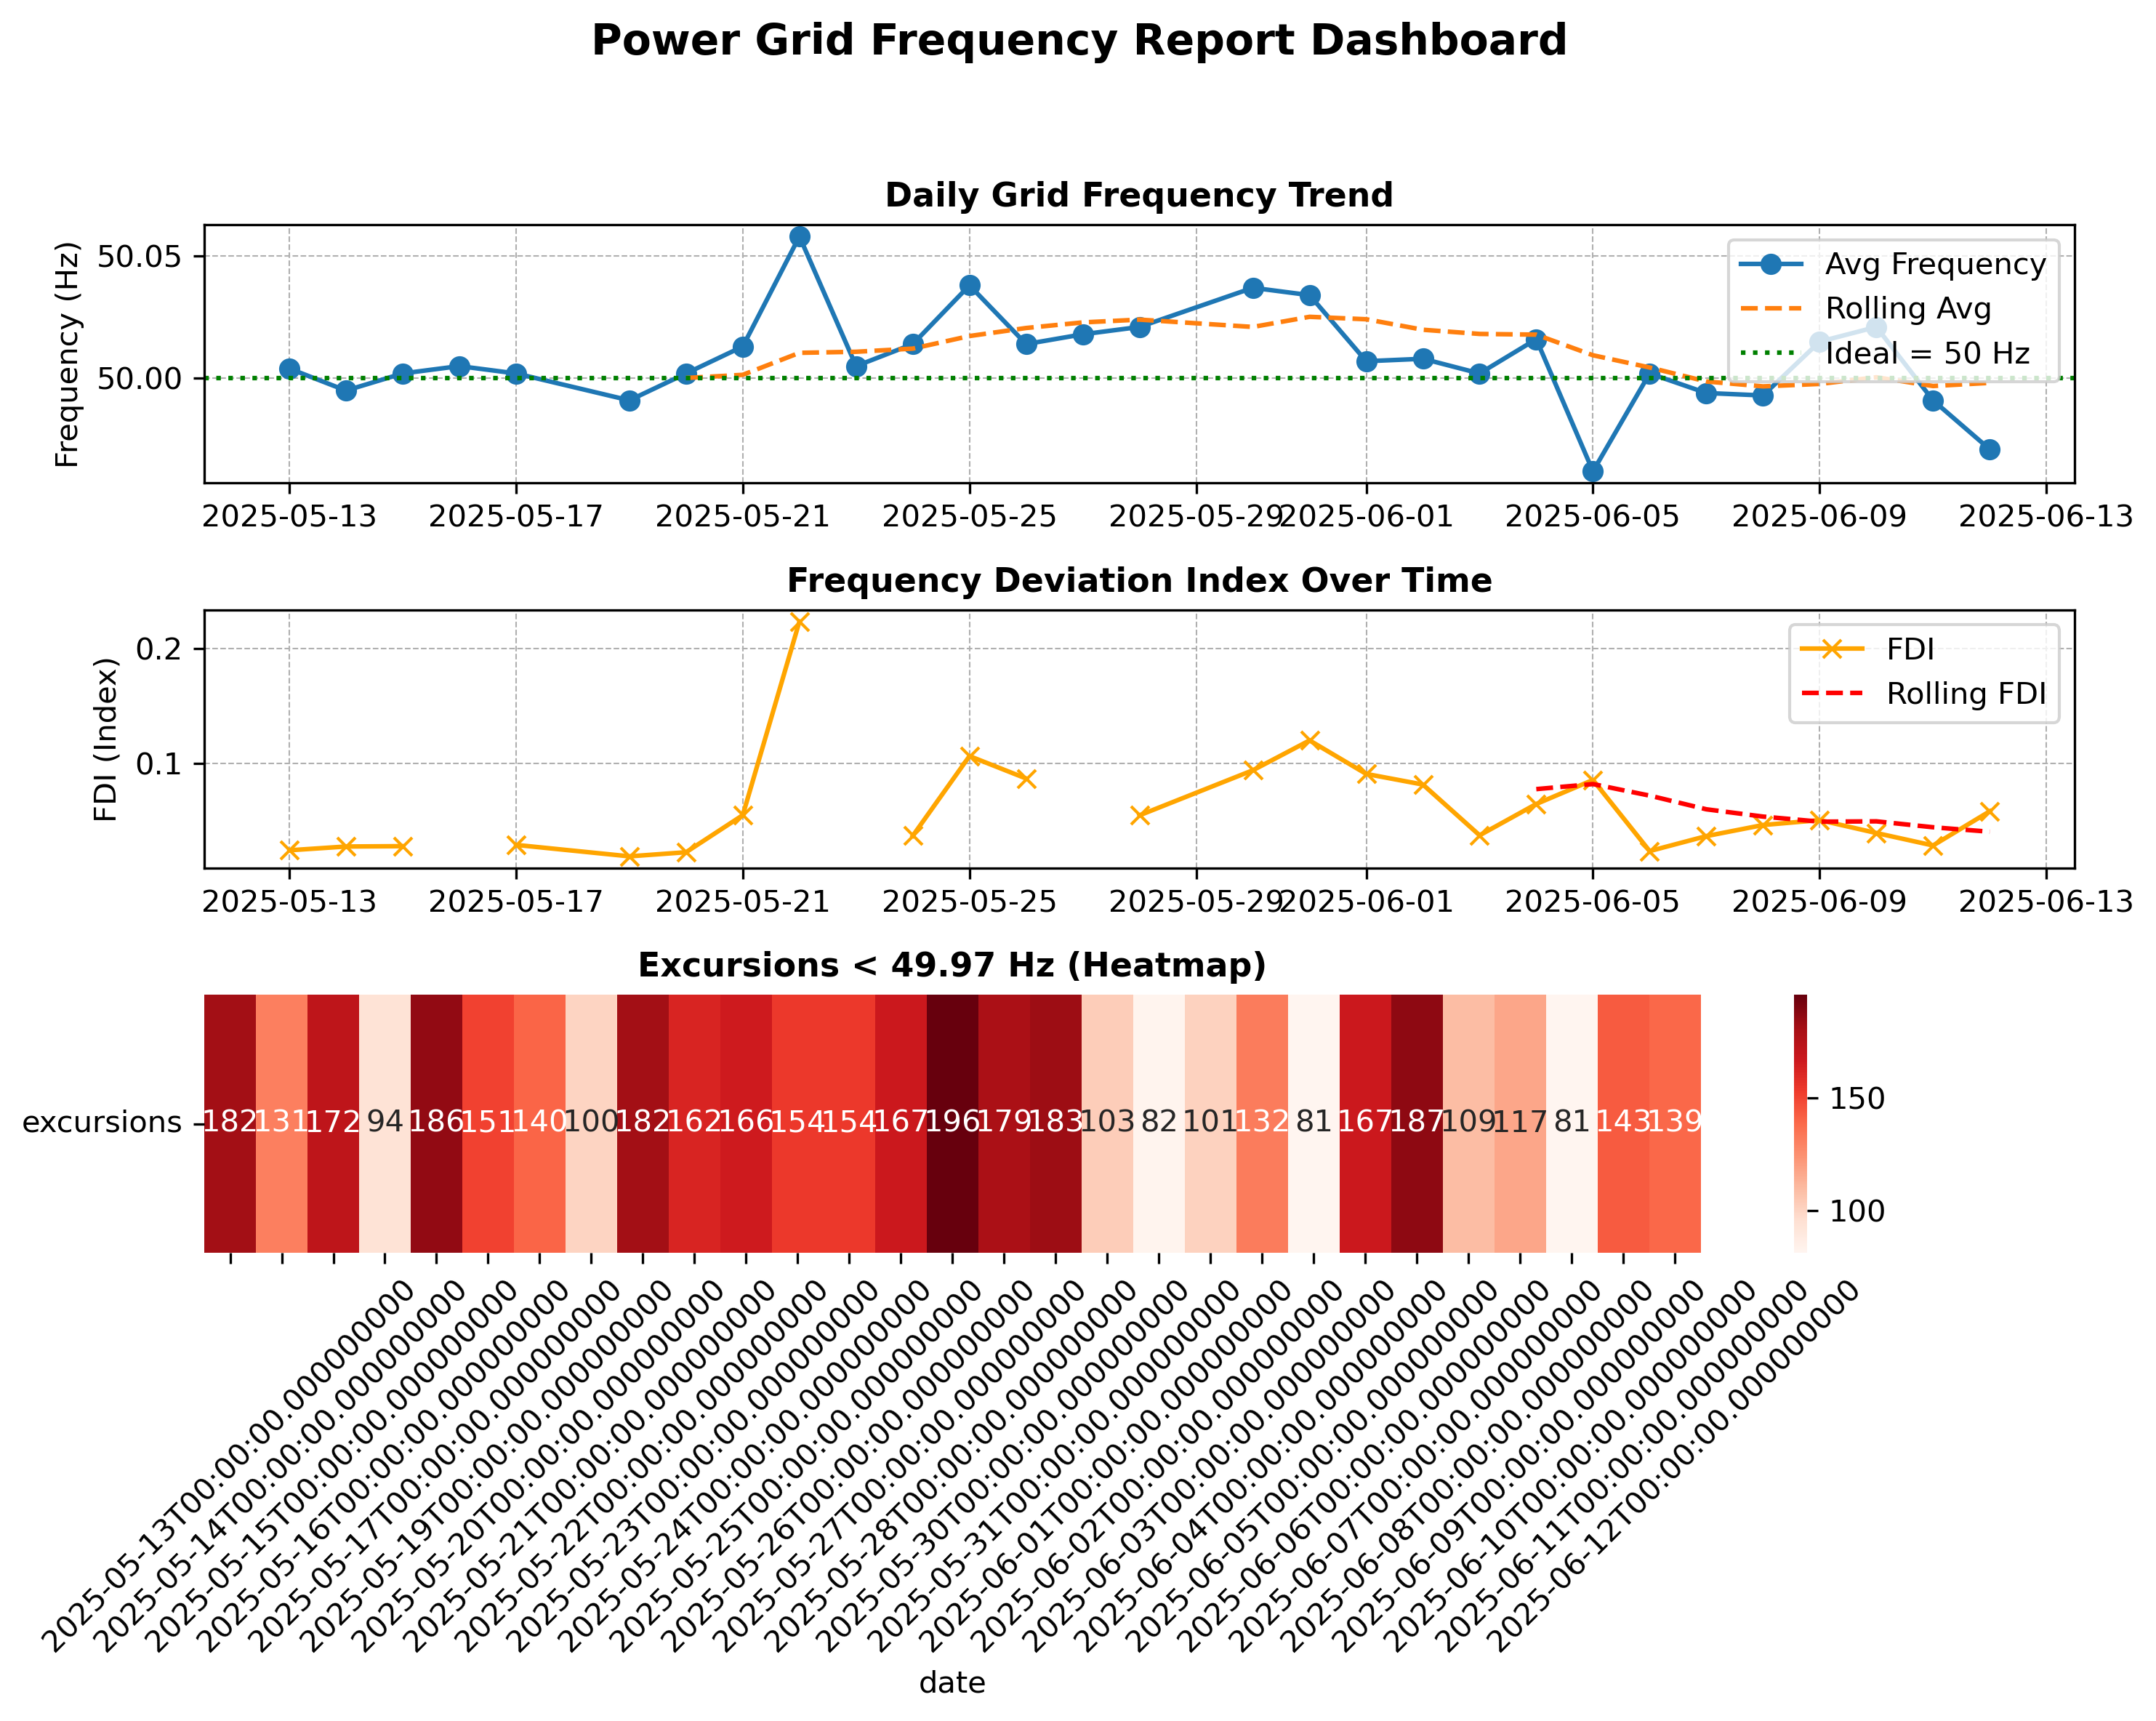

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

# --------------------------------------
# 📊 Load merged dataset
# --------------------------------------
df = pd.read_csv("simulation_input_matlab.csv")
df.columns = df.columns.str.strip().str.lower()
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values(by='date')

# --------------------------------------
# ➕ Rolling Averages
# --------------------------------------
df['rolling_avg_freq'] = df['average frequency'].rolling(window=7).mean()
df['rolling_fdi'] = df['fdi'].rolling(window=7).mean()

# --------------------------------------
# 🔍 Add fallback if excursion column missing
# --------------------------------------
if 'excursions < 49.97 hz' not in df.columns:
    print("⚠️ Adding simulated excursion data for demo.")
    np.random.seed(42)
    df['excursions < 49.97 hz'] = np.random.randint(80, 200, size=len(df))

# --------------------------------------
# 🎨 Plot setup
# --------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(10, 8), dpi=300)
fig.suptitle("Power Grid Frequency Report Dashboard", fontsize=14, weight='bold')

# --------------------------------------
# Plot 1: Frequency Trend
# --------------------------------------
axs[0].plot(df['date'], df['average frequency'], marker='o', label='Avg Frequency')
axs[0].plot(df['date'], df['rolling_avg_freq'], linestyle='--', label='Rolling Avg')
axs[0].axhline(50.00, color='green', linestyle=':', label='Ideal = 50 Hz')
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Daily Grid Frequency Trend", fontsize=11, weight='bold')
axs[0].legend()
axs[0].grid(True, linestyle='--', linewidth=0.5)

# --------------------------------------
# Plot 2: FDI Over Time
# --------------------------------------
axs[1].plot(df['date'], df['fdi'], marker='x', label='FDI', color='orange')
axs[1].plot(df['date'], df['rolling_fdi'], linestyle='--', label='Rolling FDI', color='red')
axs[1].set_ylabel("FDI (Index)")
axs[1].set_title("Frequency Deviation Index Over Time", fontsize=11, weight='bold')
axs[1].legend()
axs[1].grid(True, linestyle='--', linewidth=0.5)

# --------------------------------------
# Plot 3: Excursions < 49.97 Hz Heatmap
# --------------------------------------
excursion_data = df[['date', 'excursions < 49.97 hz']].dropna()
heatmap_data = excursion_data.set_index('date').T
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='.0f', ax=axs[2], cbar=True)
axs[2].set_title("Excursions < 49.97 Hz (Heatmap)", fontsize=11, weight='bold')
axs[2].set_yticklabels(['excursions'], rotation=0)
axs[2].set_xlabel("date")
axs[2].tick_params(axis='x', labelrotation=45)

# --------------------------------------
# Layout & Export
# --------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Power_Grid_Dashboard_Full.png", dpi=300)
plt.show()


In [16]:
df[df['date'].dt.year == 2024][['date', 'fdi', 'excursions < 49.97 hz']].head(10)


Empty DataFrame
Columns: [date, fdi, excursions < 49.97 hz]
Index: []

In [17]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print("✅ Date range:", df['date'].min(), "to", df['date'].max())


✅ Date range: 2025-05-13 00:00:00 to 2025-06-12 00:00:00


In [18]:
./pdf_reports/


SyntaxError: invalid syntax (333217424.py, line 1)